In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import bisect

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
indexData = pd.read_csv('../data/indexData_webspam_uint16.txt', sep='\t', header=None)

In [3]:
header = ['Term', 'Li_Len', '1s_Qnt', '1rl_Avg', 'Liwo1_Len', 'C_Li_Len', 'C_Liwo1_Len', 'Bitmap_Bytes',
          'Bitmap_BytesOnDisk', 'EWAH_bitmap_Bytes', 'EWAH_bitmap_BytesOnDisk', 'Bitmap_1s']
indexData.columns = header

In [4]:
#indexData['Bitmap_Bytes'] = indexData.Li_Len / 8 + 1
indexData['Li_Bytes'] = indexData.Li_Len * 4
indexData['Liwo1_Bytes'] = indexData.Liwo1_Len * 4
indexData['C_Li_Bytes'] = indexData.C_Li_Len * 4
indexData['C_Liwo1_Bytes'] = indexData.C_Liwo1_Len * 4
indexData['Ones_Ratio'] = indexData['1s_Qnt'] / indexData.Li_Len

# SS_Ratio (Space Saving): 1 - (CompressedSize / UncompressedSize) #
indexData['SS_Ratio_Li'] = 1 - (indexData.C_Li_Bytes / indexData.Li_Bytes)
indexData['SS_Ratio_Liwo1'] = 1 - (indexData.C_Liwo1_Bytes / indexData.Liwo1_Bytes)

indexData['SS_Ratio_Hybrid_Un'] = 1 - (indexData.Liwo1_Bytes + indexData.Bitmap_Bytes) / indexData.Li_Bytes
indexData['SS_Ratio_Hybrid_Co'] = 1 - (indexData.C_Liwo1_Bytes + indexData.EWAH_bitmap_Bytes) / indexData.Li_Bytes

indexData['SS_Ratio_Hybrid_Un_woBitmap'] = 1 - (indexData.Liwo1_Bytes) / indexData.Li_Bytes
indexData['SS_Ratio_Hybrid_Co_woBitmap'] = 1 - (indexData.C_Liwo1_Bytes) / indexData.Li_Bytes

In [5]:
indexData[indexData.columns[1:]]
#indexData[['SS_Ratio_Li', 'SS_Ratio_Liwo1', 'SS_Ratio_Hybrid_Un', 'SS_Ratio_Hybrid_Co']]

,Li_Len,1s_Qnt,1rl_Avg,Liwo1_Len,C_Li_Len,C_Liwo1_Len,Bitmap_Bytes,Bitmap_BytesOnDisk,EWAH_bitmap_Bytes,EWAH_bitmap_BytesOnDisk,...,Liwo1_Bytes,C_Li_Bytes,C_Liwo1_Bytes,Ones_Ratio,SS_Ratio_Li,SS_Ratio_Liwo1,SS_Ratio_Hybrid_Un,SS_Ratio_Hybrid_Co,SS_Ratio_Hybrid_Un_woBitmap,SS_Ratio_Hybrid_Co_woBitmap
0,984654,93752,1.177,890902,172285,159533,11720,11728,48,64,...,3563608,689140,638132,0.095,0.825,0.821,0.092,0.838,0.095,0.838
1,11367,9,1.000,11358,3847,3850,2,10,4,20,...,45432,15388,15400,0.001,0.662,0.661,0.001,0.661,0.001,0.661
2,76412,625,1.023,75787,20284,20238,80,88,4,20,...,303148,81136,80952,0.008,0.735,0.733,0.008,0.735,0.008,0.735
3,7493,218,5.450,7275,2612,2587,28,36,4,20,...,29100,10448,10348,0.029,0.651,0.644,0.028,0.655,0.029,0.655
4,4883,4,1.000,4879,1962,1960,2,10,4,20,...,19516,7848,7840,0.001,0.598,0.598,0.001,0.598,0.001,0.599
5,3867,4,1.000,3863,1580,1593,2,10,4,20,...,15452,6320,6372,0.001,0.591,0.588,0.001,0.588,0.001,0.588
6,4494,8,1.000,4486,1730,1748,2,10,4,20,...,17944,6920,6992,0.002,0.615,0.610,0.002,0.611,0.002,0.611
7,4887,1,1.000,4886,1790,1799,2,10,4,20,...,19544,7160,7196,0.000,0.634,0.632,0.000,0.632,0.000,0.632
8,4089,123,3.237,3966,1667,1661,16,24,4,20,...,15864,6668,6644,0.030,0.592,0.581,0.029,0.594,0.030,0.594
9,4095,1,1.000,4094,1568,1559,2,10,4,20,...,16376,6272,6236,0.000,0.617,0.619,0.000,0.619,0.000,0.619


In [6]:
# Size of vocabulary: 14813510 (terms) #
# 2134281 / 14813510 = 0.144076657 #
indexData[indexData.columns[9:]].describe()

,EWAH_bitmap_Bytes,EWAH_bitmap_BytesOnDisk,Bitmap_1s,Li_Bytes,Liwo1_Bytes,C_Li_Bytes,C_Liwo1_Bytes,Ones_Ratio,SS_Ratio_Li,SS_Ratio_Liwo1,SS_Ratio_Hybrid_Un,SS_Ratio_Hybrid_Co,SS_Ratio_Hybrid_Un_woBitmap,SS_Ratio_Hybrid_Co_woBitmap
count,175076.000,175076.000,175076.000,175076.000,175076.000,175076.000,175076.000,175076.000,175076.000,175076.000,175076.000,175076.000,175076.000,175076.000
mean,4.371,20.371,938.630,51938.777,48184.257,12119.291,11667.434,0.030,0.582,0.572,0.024,0.578,0.030,0.589
std,14.637,14.637,29916.173,396767.698,309611.087,58989.851,51958.633,0.071,0.140,0.165,0.062,0.155,0.071,0.134
min,2.000,18.000,1.000,8.000,4.000,8.000,8.000,0.000,-0.500,-1.000,0.000,-0.500,0.000,0.000
25%,4.000,20.000,1.000,828.000,796.000,360.000,356.000,0.002,0.500,0.493,0.001,0.494,0.002,0.501
50%,4.000,20.000,3.000,3588.000,3536.000,1468.000,1460.000,0.007,0.599,0.595,0.005,0.598,0.007,0.602
75%,4.000,20.000,20.000,13308.000,13204.000,5028.000,5016.000,0.023,0.681,0.677,0.019,0.683,0.023,0.687
max,3100.000,3116.000,6319439.000,35601292.000,12304772.000,2630420.000,1315868.000,0.997,0.926,0.912,0.965,0.992,0.997,0.995


In [7]:
bins = np.array((.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.), dtype=np.float64)
count_won_SS_Ratio_Hybrid_Co = np.zeros(10, dtype=np.float64)
count_lost_SS_Ratio_Hybrid_Co = np.zeros(10, dtype=np.float64)

#won_SS_SS_Ratio_Hybrid_Co = indexData[indexData['SS_Ratio_Hybrid_Co'] > indexData['SS_Ratio_Hybrid_Co']]['SS_Ratio_Hybrid_Co']
won_SS_Ratio_Hybrid_Co = np.array(indexData.query('SS_Ratio_Hybrid_Co > SS_Ratio_Li')['SS_Ratio_Hybrid_Co'])
lost_SS_Ratio_Hybrid_Co = np.array(indexData.query('SS_Ratio_Hybrid_Co <= SS_Ratio_Li')['SS_Ratio_Hybrid_Co'])

# Interval Type [) #
for SS_Ratio_Hybrid_Co in won_SS_Ratio_Hybrid_Co:
    count_won_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1
for SS_Ratio_Hybrid_Co in lost_SS_Ratio_Hybrid_Co:
    # First interval includes NEGATIVE values #
    count_lost_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1
    
# Slower! #
#for index, row in indexData.iterrows():
#    if (row.SS_Ratio_Hybrid_Co > row.SS_Ratio_Li):
#        count_won_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, row.SS_Ratio_Hybrid_Co)] += 1
#    else: # row.SS_Ratio_Hybrid_Co <= row.SS_Ratio_Li] #
#        count_lost_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, row.SS_Ratio_Hybrid_Co)] += 1

count_won_SS_Ratio_Hybrid_Co = (count_won_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100
count_lost_SS_Ratio_Hybrid_Co = (count_lost_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100

print 'Bin\t\tWon\t\tLost'
previousBin = 0.0
totalWon = 0.0
totalLost = 0.0
for won, lost, bi in zip(count_won_SS_Ratio_Hybrid_Co, count_lost_SS_Ratio_Hybrid_Co, bins):
    print '[%.1f, %.1f)\t%.2f\t\t%.2f' %(previousBin, bi, won, lost)
    previousBin = bi
    totalWon += won
    totalLost += lost
print 'Total\t\t%.2f\t\t%.2f' %(totalWon, totalLost)


Bin		Won		Lost
[0.0, 0.1)	0.00		1.11
[0.1, 0.2)	0.00		0.78
[0.2, 0.3)	0.00		1.17
[0.3, 0.4)	0.23		6.65
[0.4, 0.5)	2.07		13.82
[0.5, 0.6)	7.43		17.19
[0.6, 0.7)	13.95		14.59
[0.7, 0.8)	11.66		7.37
[0.8, 0.9)	1.69		0.13
[0.9, 1.0)	0.15		0.00
Total		37.18		62.82


In [8]:
won_Hybrid_Co = indexData.query('SS_Ratio_Hybrid_Co > SS_Ratio_Li')
lost_Hybrid_Co = indexData.query('SS_Ratio_Hybrid_Co <= SS_Ratio_Li')

print 'Posting List Lenght (Li_Bytes)'
print '\tAverage\t\tStd\t\tMin\t\tMax'
print 'Won\t%.2f\t%.2f\t%i\t\t%i' %(won_Hybrid_Co.Li_Bytes.mean(), won_Hybrid_Co.Li_Bytes.std(),
                                    won_Hybrid_Co.Li_Bytes.min(), won_Hybrid_Co.Li_Bytes.max())
print 'Lost\t%.2f\t\t%.2f\t\t%i\t\t%i' %(lost_Hybrid_Co.Li_Bytes.mean(), lost_Hybrid_Co.Li_Bytes.std(),
                                         lost_Hybrid_Co.Li_Bytes.min(), lost_Hybrid_Co.Li_Bytes.max())

print ''
print 'Average 1\'s run Lenght (1rl_Avg)'
print '\tAverage\t\tStd\t\tMin\t\tMax'
print 'Won\t%.2f\t\t%.2f\t\t%.4f\t\t%.4f' %(won_Hybrid_Co['1rl_Avg'].mean(), won_Hybrid_Co['1rl_Avg'].std(),
                                            won_Hybrid_Co['1rl_Avg'].min(), won_Hybrid_Co['1rl_Avg'].max())
print 'Lost\t%.2f\t\t%.2f\t\t%.4f\t\t%.4f' %(lost_Hybrid_Co['1rl_Avg'].mean(), lost_Hybrid_Co['1rl_Avg'].std(),
                                             lost_Hybrid_Co['1rl_Avg'].min(), lost_Hybrid_Co['1rl_Avg'].max())

print ''
print '1\'s Ratio (Ones_Ratio)'
print '\tAverage\t\tStd\t\tMin\t\tMax'
print 'Won\t%.2f\t\t%.2f\t\t%.4f\t\t%.4f' %(won_Hybrid_Co['Ones_Ratio'].mean(), won_Hybrid_Co['Ones_Ratio'].std(),
                                            won_Hybrid_Co['Ones_Ratio'].min(), won_Hybrid_Co['Ones_Ratio'].max())
print 'Lost\t%.2f\t\t%.2f\t\t%.4f\t\t%.4f' %(lost_Hybrid_Co['Ones_Ratio'].mean(), lost_Hybrid_Co['Ones_Ratio'].std(),
                                             lost_Hybrid_Co['Ones_Ratio'].min(), lost_Hybrid_Co['Ones_Ratio'].max())

Posting List Lenght (Li_Bytes)
	Average		Std		Min		Max
Won	129904.83	642997.58	40		35601292
Lost	5790.37		12619.57		8		319152

Average 1's run Lenght (1rl_Avg)
	Average		Std		Min		Max
Won	1.92		10.90		1.0000		389.0000
Lost	1.05		0.33		1.0000		66.0000

1's Ratio (Ones_Ratio)
	Average		Std		Min		Max
Won	0.04		0.09		0.0001		0.9974
Lost	0.02		0.05		0.0001		0.7143


In [9]:
count_won_SS_Ratio_Hybrid_Un = np.zeros(10, dtype=np.float64)
#count_lost_SS_Ratio_Hybrid_Un = np.zeros(10, dtype=np.float64)

won_SS_Ratio_Hybrid_Un = np.array(indexData.query('SS_Ratio_Hybrid_Un > 0')['SS_Ratio_Hybrid_Un'])
#lost_SS_SS_Ratio_Hybrid_Un = np.array(indexData.query('SS_Ratio_Hybrid_Un <= 0')['SS_Ratio_Hybrid_Un'])

# Interval Type [) #
for SS_Ratio_Hybrid_Un in won_SS_Ratio_Hybrid_Un:
    count_won_SS_Ratio_Hybrid_Un[bisect.bisect_right(bins, SS_Ratio_Hybrid_Un)] += 1
#for SS_Ratio_Hybrid_Co in lost_SS_SS_Ratio_Hybrid_Un:
#    count_lost_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1

count_won_SS_Ratio_Hybrid_Un = (count_won_SS_Ratio_Hybrid_Un / indexData.shape[0]) * 100
#count_lost_SS_SS_Ratio_Hybrid_Co = (count_lost_SS_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100

print 'Bin\t\tWon'
previousBin = 0.0
totalWon = 0.0
for won, bi in zip(count_won_SS_Ratio_Hybrid_Un, bins):
    print '[%.1f, %.1f)\t%.2f' %(previousBin, bi, won)
    previousBin = bi
    totalWon += won
print 'Total\t\t%.2f' %(totalWon)



Bin		Won
[0.0, 0.1)	94.75
[0.1, 0.2)	3.17
[0.2, 0.3)	1.09
[0.3, 0.4)	0.46
[0.4, 0.5)	0.24
[0.5, 0.6)	0.09
[0.6, 0.7)	0.07
[0.7, 0.8)	0.04
[0.8, 0.9)	0.03
[0.9, 1.0)	0.07
Total		100.00


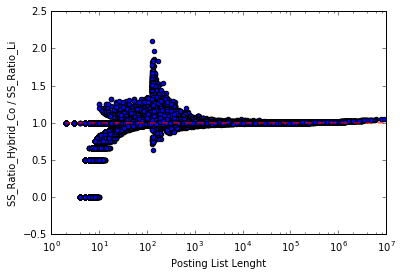

In [10]:
# SS_Ratio_Hybrid_Co / SS_Ratio_Li #

SS_Ratio_Hybrid_Co_over_SS_Ratio_Li = indexData.SS_Ratio_Hybrid_Co / indexData.SS_Ratio_Li

start = indexData.Li_Len.min()
stop = indexData.Li_Len.max()

s = np.arange(start, stop, 10, dtype=np.int64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(indexData.Li_Len, SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)

ax.set_xlabel('Posting List Lenght')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xscale('log')
#ax.set_yscale('log')

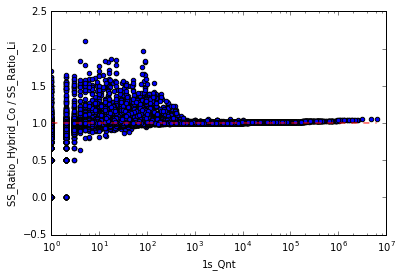

In [11]:
start = indexData['1s_Qnt'].min()
stop = indexData['1s_Qnt'].max()

s = np.arange(start, stop, 10, dtype=np.int64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(indexData['1s_Qnt'], SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)
ax.set_xlabel('1s_Qnt')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xscale('log')

(0.0, 1.1)

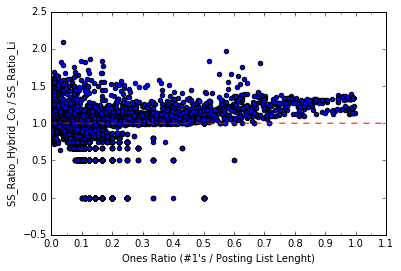

In [12]:
# How many ones do I need to win? #
# X-axis : One's proportion respect to Posting List Length #
# Y-axis : Hybrid Compression Ratio: HybridCompression / PForCompression #

start = 0.0
stop = 1.1

size = indexData.shape[0]

s = np.linspace(start, stop, size, dtype=np.float64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.scatter(indexData.Ones_Ratio, SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)
ax.plot(s, threshold, color='r', linestyle='--')
# Tickers #
min_x = MultipleLocator(0.05)
max_x = MultipleLocator(0.1)
ax.xaxis.set_major_locator(max_x)
ax.xaxis.set_minor_locator(min_x)
ax.set_xlabel('Ones Ratio (#1\'s / Posting List Lenght)')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xlim([0.0, 1.1])